In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
workDir = '/home/chantal/Chazy/Bulk/515_806/data/'
figDir = '/home/chantal/Chazy/Bulk/515_806/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeqBulk = 'bulk-core'


nprocs = 20

In [3]:
%%R
library(phyloseq)
library(tidyr)
library(plyr); library(dplyr)
library(DESeq2)
library(foreach)
library(doParallel)
library(ggplot2)
library(gridExtra)
library(reshape2)
library(RColorBrewer)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/f

#### Read in sample metadata and OTU table

In [4]:
%%R

F = file.path(physeqDir, physeqBulk)
print(F)
physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data
physeq.Bulk = prune_samples((physeq.Bulk.m$Land_Management != "PAS"),
                           physeq.Bulk)
physeq.Bulk.m = physeq.Bulk %>% sample_data


physeq.Bulk

[1] "/home/chantal/Chazy/data/phyloseq//bulk-core"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 20140 taxa and 176 samples ]
sample_data() Sample Data:       [ 176 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 20140 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 20140 tips and 20139 internal nodes ]


In [5]:
%%R
#Rarefy samples to 9500 seqs / sample
physeq.Bulk.r = rarefy_even_depth(physeq.Bulk, sample.size = 9500, rngseed = 23435, replace = TRUE,
                          trimOTUs = TRUE, verbose = TRUE)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: `set.seed(23435)` was used to initialize repeatable random subsampling.

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Please record this for your records so others can reproduce.

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Try `set.seed(23435); .Random.seed` for the full vector

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: ...

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 7 samples removedbecause they contained fewer reads than `sample.size`.

  res = super(Function, self).__call__(

In [6]:
%%R
get_l2fc = function(physeq.obj, sparsity_threshold) {
    physeq.md = sample_data(physeq.obj)
   
    p = filter_taxa(physeq.obj, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)
 
    dds = phyloseq_to_deseq2(p, ~ Till*OM)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
        
    theta = 1
    r = results(dds, independentFiltering = FALSE)
    r$OTU = rownames(r)
   
    d = data.frame(r[, c("OTU","log2FoldChange", "lfcSE", "padj")])

   # d$padj = p.adjust(p, method = "BH")
    TT = data.frame(tax_table(p))
    TT$OTU = rownames(TT)
    d = left_join(d, TT)


    d
}

In [7]:
%%R
# adding range of sparsity thresholds (all pairwise)

sdms = as.data.frame(seq(0.05,0.95,0.05))
colnames(sdms) = 'sparsity_threshold'
#cat('Number of pairwise combinations of variables:', sdms.P %>% nrow, '\n\n')
head(sdms) 

  sparsity_threshold
1               0.05
2               0.10
3               0.15
4               0.20
5               0.25
6               0.30


In [8]:
%%R
registerDoParallel(8)

df.l2fc = tbl_df(mdply(sdms, 
                       get_l2fc, 
                       .parallel = TRUE, 
                       physeq.obj = physeq.Bulk.r))
df.l2fc

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:1

Source: local data frame [41,281 x 13]

   sparsity_threshold       OTU log2FoldChange     lfcSE      padj    Rank1
                (dbl)     (chr)          (dbl)     (dbl)     (dbl)   (fctr)
1                0.05  OTU.4088      0.2113494 0.4817605 0.9991981 Bacteria
2                0.05  OTU.5225     -0.5121937 0.4671782 0.9419780 Bacteria
3                0.05  OTU.3693      0.4789666 0.4636989 0.9419780 Bacteria
4                0.05  OTU.7366      0.2235389 0.4558897 0.9991981 Bacteria
5                0.05  OTU.1692     -0.1209687 0.5027891 0.9991981 Bacteria
6                0.05 OTU.13340     -0.4303184 0.3858725 0.9392960 Bacteria
7                0.05 OTU.22168     -0.3484264 0.3939802 0.9724352 Bacteria
8                0.05 OTU.12078      0.3768428 0.5113031 0.9825445 Bacteria
9                0.05 OTU.13161      0.1879442 0.4003288 0.9991981 Bacteria
10               0.05  OTU.8122     -0.3671800 0.4093459 0.9724352 Bacteria
..                ...       ...            ...  

In [9]:
%%R
summarise(df.l2fc,
  meanl2fc = mean(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

    meanl2fc
       (dbl)
1 0.05689364


In [10]:
%%R
summarise(df.l2fc,
  sdl2fc = sd(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

    sdl2fc
     (dbl)
1 0.492684


In [11]:
%%R
df.l2fc$padj2 = p.adjust(df.l2fc$padj, method = "BH")

In [12]:
%%R
r = filter(df.l2fc, padj2 <=0.10)
length(unique(r$OTU))

[1] 20


In [13]:
%%R

padj.cutoff = 0.10

df.l2fc.rejH = df.l2fc %>%
    filter(padj2 <= padj.cutoff) %>%
    group_by(sparsity_threshold) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.rejH %>% head(n=6)

Source: local data frame [6 x 2]

  sparsity_threshold n_reject_hypo
               (dbl)         (int)
1               0.05            13
2               0.10            13
3               0.15            13
4               0.20            14
5               0.25            15
6               0.30            15


In [18]:
%%R

padj.cutoff = 0.10

df.l2fc.rejH.s = df.l2fc %>%
    filter(padj2 < padj.cutoff) %>%
    group_by(sparsity_threshold) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.rejH.s %>% head(n=10) %>% as.data.frame

   sparsity_threshold n_reject_hypo
1                0.05            13
2                0.10            13
3                0.15            13
4                0.20            14
5                0.25            15
6                0.30            15
7                0.35            16
8                0.40            16
9                0.45            17
10               0.50            18


In [19]:
%%R
# max number of rejected hypos 
max.rejH = df.l2fc.rejH.s %>%
    arrange(desc(n_reject_hypo)) %>%
    head(n=1)
max.rejH = max.rejH$sparsity_threshold
max.rejH

[1] 0.5


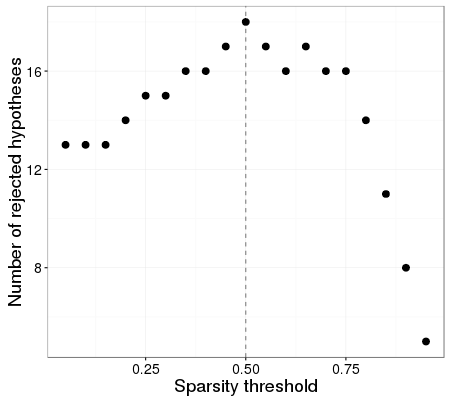

In [20]:
%%R -w 450 -h 400

ggplot(df.l2fc.rejH.s, aes(sparsity_threshold, n_reject_hypo)) +
    geom_point(size=3) +
    geom_vline(xintercept=max.rejH, linetype='dashed', alpha=0.5) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=18),
        axis.title.y = element_text(vjust=1)
        )

In [21]:
%%R
df.l2fc.f = df.l2fc %>%
    filter(sparsity_threshold == max.rejH) 

df.l2fc.f %>% nrow

[1] 1488


In [24]:
%%R #-i workDir
# Writing out l2fc table

outFile = 'data/l2fc_Till*OM.txt'
write.table(df.l2fc.f, 'data/l2fc_Till*OM.txt', sep='\t', quote=FALSE, row.names=FALSE)

In [25]:
%%R
df.l2fc = read.table('data/l2fc_Till*OM.txt', sep='\t', header = TRUE)

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [27]:
%%R
resp = df.l2fc %>% filter(padj2 <=0.10) %>% summarise(resp = n())
resp %>% as.data.frame

  resp
1   18


In [29]:
%%R
ggsave(filename = "data/figs/EnrichedNumoverTime.jpg", plot = p, width =12, height =6)

####Function arguments

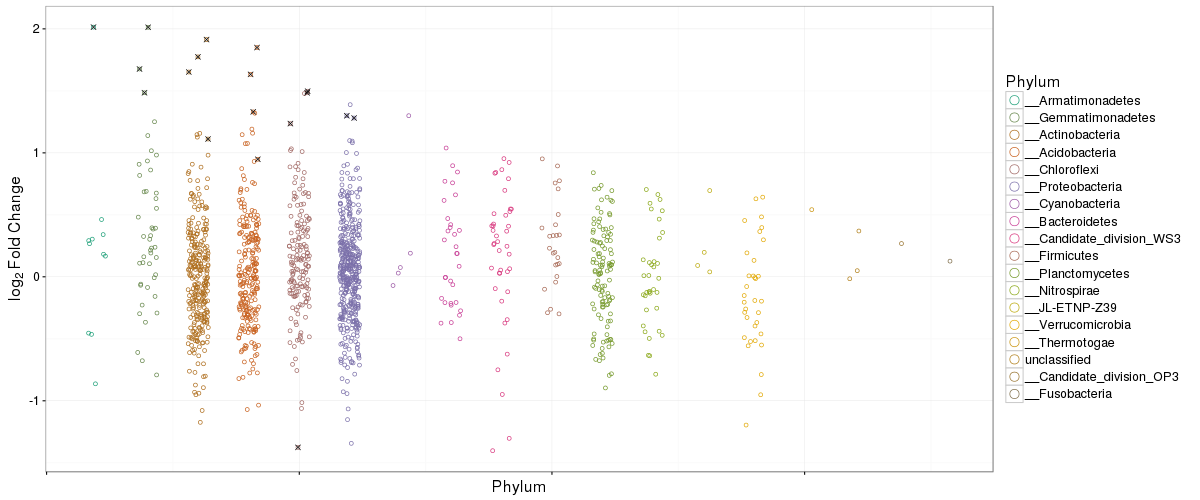

In [28]:
%%R -w 1200 -h 500
d = df.l2fc
FDR = 0.10

d$Rank2 = as.character(d$Rank2)
d$Rank2[is.na(d$Rank2)] = "unclassified"
d$Rank2 = factor(d$Rank2)

max.l2fc = ddply(d, .(Rank2), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank2, max.l2fc[order(-max.l2fc$M),]$Rank2)

M = max(as.numeric(d$Rank2), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank2)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank2))

p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj2 <= 0.10), color = "black", shape = 4, size = 2)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Phylum", color = "Phylum")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16)) #+ guides(color = FALSE)

p

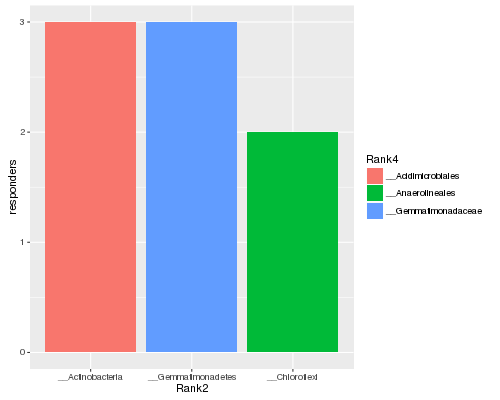

In [33]:
%%R -w 500 -h 400
dcounts = df.l2fc %>%
          filter(!is.na(log2FoldChange)) %>%
          filter(!is.na(padj)) %>%
          group_by(Rank2, Rank3, Rank4, Rank5) %>%
          summarize(responders = sum(padj2<= 0.10))
dcounts = filter(dcounts, responders > 1)
dcounts$Rank2 <- droplevels(dcounts$Rank2) 
dcounts$Rank2 = reorder(dcounts$Rank2, -dcounts$responders)


p = ggplot(dcounts, aes(x = Rank2 , y = responders, fill = Rank4)) +
    geom_bar(stat = "identity") #+
    #facet_wrap( ~ Rank2, ncol = 4, nrow = 7) 

p